# Bayesian filtering for nonlinear Gaussian dynamical systems

Wouter Kouw | Last update: 09-12-2021

Consider a discrete-time dynamic system with observations $y_k \in \mathbb{R}^{d_y}$ and latent states $x_k \in \mathbb{R}^{d_x}$. These are subject to the following dynamics:

$$\begin{align}
x_k =&\ f(x_{k-1}) + q_{k-1} \\
y_k =&\ h(x_k) + r_{k} \, ,
\end{align}$$

where $f$ and $h$ are static nonlinear functions, $q_{k-1}$ represents process noise and $r_{k}$ is measurement noise. Both sources of noise are Gaussian distributed with zero mean:

$$q_{k-1} \sim \mathcal{N}(0, Q) \, , \qquad r_k \sim \mathcal{N}(0, R) \, ,$$

with covariance matrices $Q$ and $R$.

## Problem: tracking a noisy pendulum

We will be tracking a pendulum whose observations are noisy. You can find this example in [Bayesian Filtering & Smoothing](https://www.cambridge.org/core/books/bayesian-filtering-and-smoothing/C372FB31C5D9A100F8476C1B23721A67) by Simon Särkkä (Ex 3.7). The state transition has the following form:

$$\begin{align*}
\underbrace{\begin{bmatrix} x_{1,k} \\ x_{2,k} \end{bmatrix}}_{x_k} = \underbrace{\begin{bmatrix} x_{1,k-1} + x_{2,k-1} \Delta t \\ x_{2,k-1} -G \sin(x_{1,k-1}) \Delta t \end{bmatrix}}_{f(x_{k-1})} + q_{k-1}
\end{align*}$$

where $x_1$ represents the angle of the pendulum, $x_2$ represents the change in angle and $G$ is gravitational acceleration. 

The measurement function is described as:

$$\begin{align*}
y_k = \underbrace{\sin(x_{1,k})}_{h(x_k)} + r_k
\end{align*}$$

We cannot observe the change in angle directly, only the height of the angle itself (i.e. $\sin(x_{1})$).

#### Data-generating process

In [1]:
using LinearAlgebra
using ProgressMeter
using Plots
pyplot();

In [2]:
# Length of time-series
T = 400
Δt = 0.01

# Gravitational acceleration
G = 9.81

# Process noise covariance
qc = 1e-3
Q = [qc*Δt^3/3 qc*Δt^2/2; qc*Δt^2/2 qc*Δt]
    
# Measurement noise variance  
R = 1e-2
     
# Initial states
x0 = [1.0, 0.0]

# Initialize data array
states = zeros(2,T)
observations = zeros(T,)

# Initialize previous state variable
prev_state = x0

for k = 1:T
    
    # State transition
    states[1,k] = prev_state[1] + prev_state[2]*Δt
    states[2,k] = prev_state[2] - G*sin(prev_state[1])*Δt
    
    # Add process noise
    states[:,k] = states[:,k] + cholesky(Q).L*randn(2)
    
    # Observation with added measurement noise
    observations[k] = sin(states[1,k]) + sqrt(R)*randn(1)[1]
    
    # Update "previous state"
    prev_state = states[:,k]
    
end    

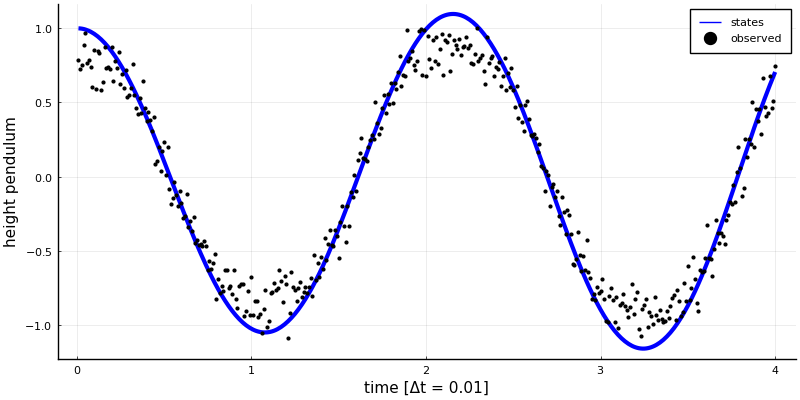

In [3]:
# Inspect data
plot((1:T).*Δt, states[1,:], linewidth=3, color="blue", xlabel="time [Δt = "*string(Δt)*"]", ylabel="height pendulum", label="states", size=(800,400))
scatter!((1:T).*Δt, observations, color="black", markersize=2,label="observed")

### Model specification

We can convert the state transition and observation likelihood from the system dynamics to probabilistic form by integrating out the noise variables:

$$\begin{align}
x_k \sim&\ \mathcal{N}(f(x_{k-1}), Q) \\
y_k \sim&\ \mathcal{N}(g(x_k), R) \, .
\end{align}$$

The noise covariance matrices are now the covariance matrices of the stochastic state transition and likelihood. In both cases, we will use an unscented transform to approximate the result of applying the nonlinear function with a Gaussian distribution.

We will need priors for the unknown variables. We will be doing recursive estimation (filtering) in this notebook, we need only define a prior for the "previous state" variable $x_{k-1}$:

$$\begin{align} 
x_{k-1} \sim \mathcal{N}(m_k, W_k^{-1}) \, ,
\end{align}$$

where $W_k$ is a precision matrix. In Bayesian inference, we often work with precision matrices instead of covariance matrices as that tends to require less matrix inversions. We will model the unknown noise precision matrices with a gamma distribution (univariate measurement noise) and a Wishart distribution (multivariate process noise). These are the conditionally [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior) for Gaussian likelihoods:

$$\begin{align} 
Q^{-1} \sim&\ \mathcal{W}(V_Q, n_Q) \\
R^{-1} \sim&\ \Gamma(a_r, b_r) \, .
\end{align}$$

With a likelihood and a set of priors, we can specify a model in a probabilistic programming language (here [ForneyLab.jl](https://github.com/biaslab/ForneyLab.jl)) and automatically infer (approximate) posteriors.

In [4]:
using ForneyLab

In [5]:
fg = FactorGraph()

# Measurement noise precision
@RV Ri ~ Gamma(placeholder(:a_R), placeholder(:b_R))

# Process noise precision
@RV Qi ~ Wishart(placeholder(:V_Q, dims=(2,2)), placeholder(:n_Q))

# Previous state vector
@RV x_kmin1 ~ GaussianMeanPrecision(placeholder(:m_x, dims=(2,)), placeholder(:W_x, dims=(2,2)))

# Nonlinear state transition function
f(x) = [x[1] + x[2]*Δt, x[2] - G*sin(x[1])*Δt]
@RV fx_k ~ Nonlinear{Unscented}(x_kmin1; g=f)

# Add process noise
@RV x_k ~ GaussianMeanPrecision(fx_k, Qi)

# Mask the state vector
@RV x_1 = dot([1., 0.], x_k)

# Nonlinear observation function
h(x) = sin(x)
@RV hx_k ~ Nonlinear{Unscented}(x_1; g=h)

# Add measurement noise
@RV y_k ~ GaussianMeanPrecision(hx_k, Ri)

# Indicate y_k will be observed
placeholder(y_k, :y_k);

ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.47.1 (20210417.1919)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11769799603831642054 -->
 
 11769799603831642054 
 
 g{Unscented} 
 nonlinear_1 
 
<!-- 7200964442915660904 -->
 
 7200964442915660904 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 11769799603831642054--7200964442915660904 -->
 
 11769799603831642054--7200964442915660904 
 
 x_kmin1 
 1 out 
 2 in1 
 
<!-- 15707164406108971955 -->
 
 15707164406108971955 
 
 dot 
 dotproduct_1 
 
<!-- 13099004617794688251 -->
 
 13099004617794688251 
 
 clamp_1 
 
<!-- 15707164406108971955--13099004617794688251 -->
 
 15707164406108971955--13099004617794688251 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 12615399910196930301 -->
 
 12615399910196930301 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 15707164406108971955--12615399910196930301 -->
 
 15707164406108971955--12615399910196930301 
 
 x_k 
 1 out 
 2 in1 
 
<!-- 7572076714573308162 -->
 
 7572076714573308162 
 
 placeholder_V_Q 
 
<!-- 18314240599931604027 -->
 
 18314240599931604027 
 
 placeholder_m_x 
 
<!-- 16861794541815506586 -->
 
 16861794541815506586 
 
 W 
 wishart_1 
 
<!-- 16861794541815506586--7572076714573308162 -->
 
 16861794541815506586--7572076714573308162 
 
 V_Q 
 1 out 
 2 v 
 
<!-- 13333063496959055474 -->
 
 13333063496959055474 
 
 placeholder_n_Q 
 
<!-- 16861794541815506586--13333063496959055474 -->
 
 16861794541815506586--13333063496959055474 
 
 n_Q 
 1 out 
 3 nu 
 
<!-- 14420421744326312879 -->
 
 14420421744326312879 
 
 placeholder_W_x 
 
<!-- 2576489981286358758 -->
 
 2576489981286358758 
 
 placeholder_b_R 
 
<!-- 18030336638603525491 -->
 
 18030336638603525491 
 
 g{Unscented} 
 nonlinear_2 
 
<!-- 18030336638603525491--15707164406108971955 -->
 
 18030336638603525491--15707164406108971955 
 
 x_1 
 1 out 
 2 in1 
 
<!-- 4789214632737044419 -->
 
 4789214632737044419 
 
 Gam 
 gamma_1 
 
<!-- 4789214632737044419--2576489981286358758 -->
 
 4789214632737044419--2576489981286358758 
 
 b_R 
 1 out 
 3 b 
 
<!-- 11609603851023295769 -->
 
 11609603851023295769 
 
 placeholder_a_R 
 
<!-- 4789214632737044419--11609603851023295769 -->
 
 4789214632737044419--11609603851023295769 
 
 a_R 
 1 out 
 2 a 
 
<!-- 10856907810642589554 -->
 
 10856907810642589554 
 
 placeholder_y_k 
 
<!-- 2184084146676702280 -->
 
 2184084146676702280 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 10856907810642589554--2184084146676702280 -->
 
 10856907810642589554--2184084146676702280 
 
 y_k 
 1 out 
 1 out 
 
<!-- 7200964442915660904--18314240599931604027 -->
 
 7200964442915660904--18314240599931604027 
 
 m_x 
 1 out 
 2 m 
 
<!-- 7200964442915660904--14420421744326312879 -->
 
 7200964442915660904--14420421744326312879 
 
 W_x 
 1 out 
 3 w 
 
<!-- 12615399910196930301--11769799603831642054 -->
 
 12615399910196930301--11769799603831642054 
 
 fx_k 
 1 out 
 2 m 
 
<!-- 12615399910196930301--16861794541815506586 -->
 
 12615399910196930301--16861794541815506586 
 
 Qi 
 1 out 
 3 w 
 
<!-- 2184084146676702280--18030336638603525491 -->
 
 2184084146676702280--18030336638603525491 
 
 hx_k 
 1 out 
 2 m 
 
<!-- 2184084146676702280--4789214632737044419 -->
 
 2184084146676702280--4789214632737044419 
 
 Ri 
 1 out 
 3 w

### Compile inference algorithm

We cannot use exact Bayesian inference here and will therefore switch to an approximate inference scheme: variational message passing.

In [6]:
# Define a factorization for the posterior
q = PosteriorFactorization(x_k, fx_k, hx_k, Qi, Ri, ids=[:xk, :fk, :hk, :Qi, :Ri])

# Define a variational message passing procedure
algorithm = messagePassingAlgorithm([x_k, fx_k, hx_k, Qi, Ri], q)

# Compile message passing procedure to an inference algorithm
code = algorithmSourceCode(algorithm);

# Import compiled functions to workspace
eval(Meta.parse(code));

# Print compiled functions (uncomment when desired)
# println(code)

### Execute inference algorithm

We execute the algorithm in an online fashion: after each timestep the posteriors for the state and noise precisions are used as priors for the next timestep.

In [7]:
# Number of iterations
num_iterations = 5

# Parameters for prior distributions
m_x_0 = [1., 0.]
W_x_0 = [1. 0.;0. 1.]
a_R_0 = 10.0
b_R_0 = 0.1
V_Q_0 = [10. 0.1;0.1 1.]
n_Q_0 = 10.0

# Initialize array to track Free Energy objective
F = zeros(T,num_iterations)

# Initialize arrays for storing parameter estimates
m_x_k = zeros(2,T)
W_x_k = zeros(2,2,T)
a_R_k = zeros(T,)
b_R_k = zeros(T,)
V_Q_k = zeros(2,2,T)
n_Q_k = zeros(T,)

# Initialize previous parameter estimates
m_x_kmin1 = m_x_0
W_x_kmin1 = W_x_0
a_R_kmin1 = a_R_0
b_R_kmin1 = b_R_0
V_Q_kmin1 = V_Q_0
n_Q_kmin1 = n_Q_0

# Initialize data dictionary
data = Dict()

# Initialize marginal distributions
marginals = Dict()
marginals[:x_kmin1] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=m_x_0, v=W_x_0)
marginals[:hx_k] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[0., 0.], w=[1. 0.;0. 1.])
marginals[:fx_k] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[0., 0.], v=[1. 0.;0. 1.])
marginals[:x_k] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[0., 0.], w=[1. 0.;0. 1.])
marginals[:x_1] = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=0.0, v=1.0)
marginals[:Ri] = ProbabilityDistribution(Univariate, Gamma, a=a_R_0, b=b_R_0)
marginals[:Qi] = ProbabilityDistribution(Wishart, v=V_Q_0, nu=n_Q_0)

# Recursive estimation procedure (posteriors at k => priors at k+1)
@showprogress for k = 1:T
    
    # Store data for current time-step
    data[:y_k] = observations[k]
    data[:m_x] = m_x_kmin1
    data[:W_x] = W_x_kmin1
    data[:a_R] = a_R_kmin1
    data[:b_R] = b_R_kmin1
    data[:V_Q] = V_Q_kmin1
    data[:n_Q] = n_Q_kmin1
    
    # Iteratively update beliefs
    for tt = 1:num_iterations
        
        # Update recognition distributions
        stepxk!(data, marginals)
        stepfk!(data, marginals)
        stephk!(data, marginals)
        stepRi!(data, marginals)
        stepQi!(data, marginals)
    end
    
    # Update book-keeping
    m_x_kmin1 = m_x_k[:,k] = ForneyLab.unsafeMean(marginals[:x_k])
    W_x_kmin1 = W_x_k[:,:,k] = ForneyLab.unsafePrecision(marginals[:x_k])
    a_R_kmin1 = a_R_k[k] = marginals[:Ri].params[:a]
    b_R_kmin1 = b_R_k[k] = marginals[:Ri].params[:b]
    V_Q_kmin1 = V_Q_k[:,:,k] = marginals[:Qi].params[:v]
    n_Q_kmin1 = n_Q_k[k] = marginals[:Qi].params[:nu]
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


### Inspect results
We can plot the estimates of the angle and the change in the angle, over time, including the uncertainty of the estimates.

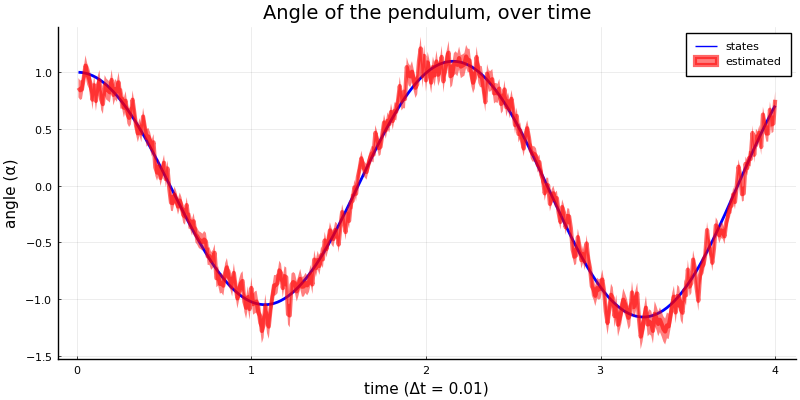

In [8]:
# Plot true states and overlay estimates
plot((1:T).*Δt, states[1,:], linewidth=2, xlabel="time (Δt = "*string(Δt)*")", ylabel="angle (α)", color="blue", label="states", size=(800,400))
plot!((1:T).*Δt, m_x_k[1,:], linewidth=3, color="red", ribbon=[sqrt.(inv.(W_x_k)[1,1,:]) sqrt.(inv.(W_x_k)[1,1,:])], alpha=0.6, label="estimated")
title!("Angle of the pendulum, over time")

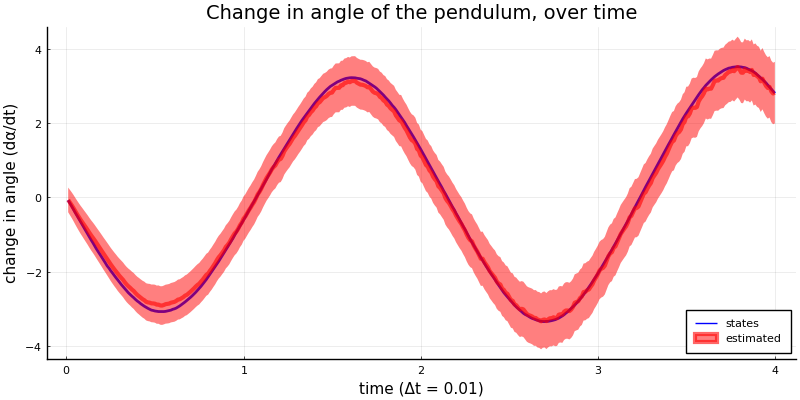

In [9]:
# Plot true states and overlay estimates
plot((1:T).*Δt, states[2,:], linewidth=2, xlabel="time (Δt = "*string(Δt)*")", ylabel="change in angle (dα/dt)", color="blue", label="states", size=(800,400))
plot!((1:T).*Δt, m_x_k[2,:], linewidth=3, color="red", ribbon=[sqrt.(inv.(W_x_k)[2,2,:]) sqrt.(inv.(W_x_k)[2,2,:])], alpha=0.6, label="estimated", legend=:bottomright)
title!("Change in angle of the pendulum, over time")

Both the angle and the change in angle are tracked nicely.